# Jaws Segmentation 



In [1]:
! pip install --user torch torchvision matplotlib numpy progressbar

! pip install albumentations==0.4.6
! pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=382b91ec98de16de0e48cf4bb59cceb604d3c426463a4b466d35a9eaa1e0ee6c
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 7.1 MB/s 
     |████████████████████████████████| 948 kB 44.4 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=ffe56d2f3c3915da674507a44e14c9a182757578a2f0495a9b47e8aa49e2b87a
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uni

In [2]:
import urllib.request
import zipfile
import os
import progressbar
from math import ceil
import torch
import gzip
import numpy as np
import glob
import matplotlib.pyplot as plt
from torchvision import transforms

import torch.nn as nn
#from scipy import stats
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.train import TrainEpoch, ValidEpoch
#import cv2
import matplotlib.ticker as mticker

In [3]:
LOCAL_DATASET_PATH = 'dataset'
AXIAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/train.zip'
AXIAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/test.zip'
CORONAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/train.zip'
CORONAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/test.zip'
SAGITTAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/train.zip'
SAGITTAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/test.zip'

In [86]:
BATCH_SIZE = 16
ENCODER = "efficientnet-b3"
ENCODER_WEIGHTS = 'imagenet'
NUM_CLASSES = 3 
CLASSES = ["background","upper_jaw" , "lower_jaw"]
ACTIVATION = None
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
LEARNING_RATE = 0.001
EPOCHS = 10
DIM = 256

## Downloading Dataset

In this part we download the publicly available dataset, you can skip it if you already have it, it should be 5.6 Gb worth of data, will give an error if already downloaded, just skip it then.

In [4]:
download_progress_bar = None
def show_progress(block_num, block_size, total_size):
    global download_progress_bar
    if download_progress_bar is None:
        download_progress_bar = progressbar.ProgressBar(maxval=total_size)
        download_progress_bar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        download_progress_bar.update(downloaded)
    else:
        download_progress_bar.finish()
        download_progress_bar = None

def download_file(url, disk_path):
    print(f'downloading {url}')
    filename, _ = urllib.request.urlretrieve(url, reporthook=show_progress)
    os.makedirs(disk_path)
    with zipfile.ZipFile(filename, 'r') as zip:
        zip.extractall(disk_path)

def download_data(to=LOCAL_DATASET_PATH):
    download_file(AXIAL_TRAINING_DATASET, os.path.join(to, 'axial', 'train'))
    download_file(AXIAL_TESTING_DATASET, os.path.join(to, 'axial', 'test'))
    download_file(CORONAL_TRAINING_DATASET, os.path.join(to, 'coronal', 'train'))
    download_file(CORONAL_TESTING_DATASET, os.path.join(to, 'coronal', 'test'))
    download_file(SAGITTAL_TRAINING_DATASET, os.path.join(to, 'sagittal', 'train'))
    download_file(SAGITTAL_TESTING_DATASET, os.path.join(to, 'sagittal', 'test'))

download_data()

downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/train.zip


100% (1687658425 of 1687658425) |########| Elapsed Time: 0:01:31 Time:  0:01:31


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/test.zip


100% (345779382 of 345779382) |##########| Elapsed Time: 0:00:17 Time:  0:00:17


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/train.zip


100% (1688318975 of 1688318975) |########| Elapsed Time: 0:01:17 Time:  0:01:17


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/test.zip


100% (347373983 of 347373983) |##########| Elapsed Time: 0:00:16 Time:  0:00:16


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/train.zip


100% (1686885165 of 1686885165) |########| Elapsed Time: 0:01:19 Time:  0:01:19


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/test.zip


100% (346507429 of 346507429) |##########| Elapsed Time: 0:00:21 Time:  0:00:21


## Explore The Dataset


In [80]:
class JawsDataset(torch.utils.data.Dataset):
    def __init__(self,
                 dicom_file_list,
                 augmentation = None,
                 preprocessing = None,
            ):
        
        self.dicom_file_list = dicom_file_list
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.dicom_file_list)

    def __getitem__(self, idx):
        #read the files and load them into numpy array 
        dicom_path = self.dicom_file_list[idx]
        label_path = dicom_path.replace('.dicom.npy.gz', '.label.npy.gz')
        
        dicom_file = gzip.GzipFile(dicom_path, 'rb')
        dicom = np.load(dicom_file)
        dicom = dicom.astype("float32")
        dicom = dicom[..., np.newaxis] # added dim from (h,w) > (h,w,1) 

        label_file = gzip.GzipFile(label_path, 'rb')
        label = np.load(label_file)
        #label = label.astype('int64') 
        #label = label[..., np.newaxis] # change dim from (h,w) > (h,w,1) 
        
        #apply augmentation + preprocessing 
        if self.augmentation:
            sample = self.augmentation(image = dicom, mask = label)
            dicom, label = sample["image"], sample["mask"] 
            label = label.unsqueeze(0).type(torch.int64) # added dim and changed data type to int64 important for masks
    
        elif self.preprocessing:
            sample = self.preprocessing(image=dicom, mask = label)
            dicom, label = sample["image"], sample["mask"] 
            label = label.unsqueeze(0).type(torch.int64) # added dim and changed data type to int64 important for masks
            
        return dicom, label

def axial_dataset_train(augmentation = None, preprocessing = None, validation_ratio = 0.1):
    files = glob.glob('dataset/axial/train/**/*.dicom.npy.gz')
    assert len(files) > 0
    validation_files_count = ceil(len(files) * validation_ratio)

    return (JawsDataset(files[validation_files_count:],
                        augmentation=augmentation), # train
            
            JawsDataset(files[:validation_files_count],
                        preprocessing = preprocessing)) # validation

def coronal_dataset_train(augmentation = None, preprocessing = None, validation_ratio = 0.1):
    files = glob.glob('dataset/coronal/train/**/*.dicom.npy.gz')
    assert len(files) > 0
    validation_files_count = ceil(len(files) * validation_ratio)

    return (JawsDataset(files[validation_files_count:],
                        augmentation=augmentation), # train
            
            JawsDataset(files[:validation_files_count],
                        preprocessing = preprocessing)) # validation

def sagittal_dataset_train(augmentation = None, preprocessing = None, validation_ratio = 0.1):
    files = glob.glob('dataset/sagittal/train/**/*.dicom.npy.gz')
    assert len(files) > 0
    validation_files_count = ceil(len(files) * validation_ratio)

    return (JawsDataset(files[validation_files_count:],
                        augmentation=augmentation), # train
            
            JawsDataset(files[:validation_files_count],
                        preprocessing = preprocessing)) # validation

def axial_dataset_test(preprocessing = None):
    files = glob.glob('dataset/axial/test/**/*.dicom.npy.gz')
    assert len(files) > 0
    return JawsDataset(files, preprocessing=preprocessing)

def coronal_dataset_test(preprocessing = None):
    files = glob.glob('dataset/coronal/test/**/*.dicom.npy.gz')
    assert len(files) > 0
    return JawsDataset(files, preprocessing=preprocessing)

def sagittal_dataset_test(preprocessing = None):
    files = glob.glob('dataset/sagittal/test/**/*.dicom.npy.gz')
    assert len(files) > 0
    return JawsDataset(files, preprocessing=preprocessing)


In [ ]:
#dataset_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST)]) 

In [81]:
def get_augmentation(h_flip = None):
    train_transform = [
        A.Resize(DIM, DIM, interpolation=0), # nearest
        A.HorizontalFlip(p=0.5) if h_flip else None,
        A.Rotate(limit = 5, interpolation=0),  # nearest
        ToTensorV2()
        ]
    return A.Compose(train_transform)

def get_preprocessing():
    _train_transform = [
        A.Resize(DIM, DIM, interpolation=0), # nearest
        ToTensorV2()
        ]
    return A.Compose(_train_transform)

In [82]:
axial_train_dataset, axial_validatiaon_dataset = axial_dataset_train(augmentation = get_augmentation(h_flip = 1), preprocessing = get_preprocessing())
coronal_train_dataset, coronal_validation_dataset = coronal_dataset_train(augmentation = get_augmentation(h_flip = 1), preprocessing = get_preprocessing())
sagittal_train_dataset, sagittal_validation_dataset = sagittal_dataset_train(augmentation = get_augmentation(), preprocessing = get_preprocessing())
print(f'axial training dataset: {len(axial_train_dataset)} slice and axial validation dataset: {len(axial_validatiaon_dataset)}')
print(f'coronal training dataset: {len(coronal_train_dataset)} slice and coronal validation dataset: {len(coronal_validation_dataset)}')
print(f'sagittal training dataset: {len(sagittal_train_dataset)} slice and sagittal validation dataset: {len(sagittal_validation_dataset)}')

axial_train_loader = torch.utils.data.DataLoader(dataset = axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_train_loader = torch.utils.data.DataLoader(dataset = coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_train_loader = torch.utils.data.DataLoader(dataset = sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial_validation_loader = torch.utils.data.DataLoader(dataset = axial_validatiaon_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_validation_loader = torch.utils.data.DataLoader(dataset = coronal_validation_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_validation_loader = torch.utils.data.DataLoader(dataset = sagittal_validation_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial training dataset: 5043 slice and axial validation dataset: 561
coronal training dataset: 7277 slice and coronal validation dataset: 809
sagittal training dataset: 7277 slice and sagittal validation dataset: 809


In [ ]:
axial_data_iter = iter(axial_train_loader)
images, labels = axial_data_iter.next()
plt.figure(figsize=(24, 6))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

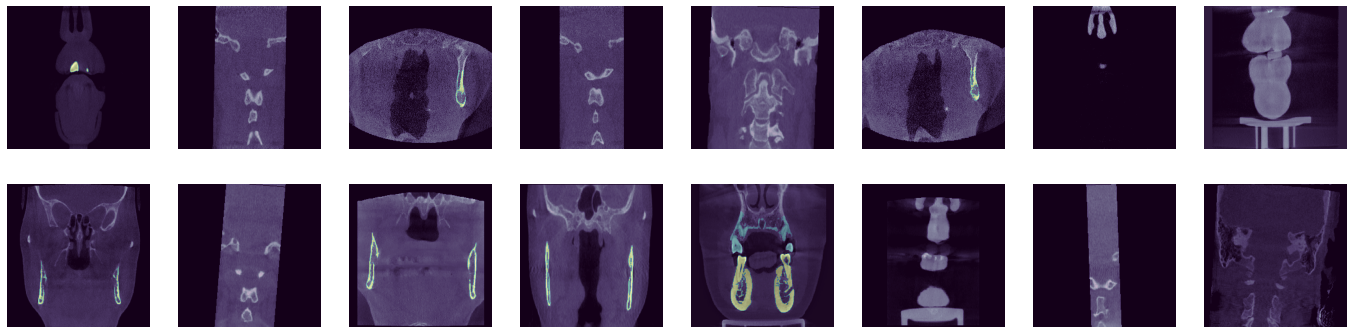

In [ ]:
coronal_data_iter = iter(coronal_train_loader)
images, labels = coronal_data_iter.next()
plt.figure(figsize=(24, 6))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

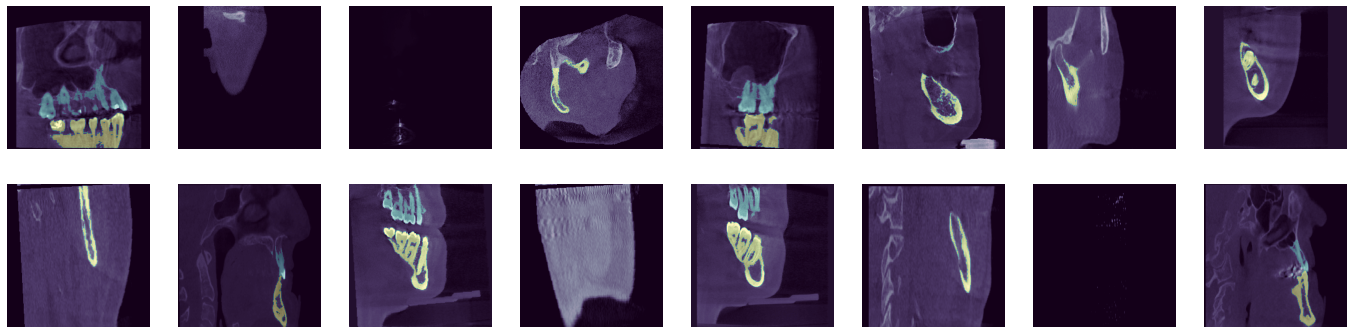

In [ ]:
sagittal_data_iter = iter(sagittal_train_loader)
images, labels = sagittal_data_iter.next()
plt.figure(figsize=(24, 6))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

## Training



### Axial dataset training

In [9]:
# define model using smp library 
model_axial = smp.Unet(encoder_name=ENCODER,
                 encoder_depth=5,
                 encoder_weights=ENCODER_WEIGHTS,
                 decoder_use_batchnorm=True, 
                 decoder_channels=(256,128, 64, 32, 16), 
                 decoder_attention_type=None,
                 in_channels=1,
                 classes=NUM_CLASSES,
                 activation=None,
                 aux_params=None)

loss = smp.losses.DiceLoss(mode="multiclass")
loss.__name__ = "Dice_loss"

metrics = []

optimizer = torch.optim.Adam(params=model_axial.parameters(), lr=LEARNING_RATE)


train_epoch = TrainEpoch(model_axial,
                                         loss = loss,
                                         metrics = metrics,
                                         optimizer = optimizer,
                                         device = DEVICE,
                                         verbose = True
)

val_epoch = ValidEpoch(model_axial,
                       loss = loss,
                       metrics = metrics,
                       device = DEVICE,
                       verbose = True
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

In [10]:
#train and save last epoch model
Train_logging_a = np.zeros(EPOCHS)
val_logging_a = np.zeros(EPOCHS)
save_model_axial_path = "./last_model_axial.pth"
for i in range(0,EPOCHS):
    
    print('\nEpoch: {}'.format(i + 1))
    
    train_logs = train_epoch.run(axial_train_loader)
    val_logs = val_epoch.run(axial_validation_loader)
    
        
    Train_logging_a[i] = train_logs["Dice_loss"]
    val_logging_a[i] = val_logs["Dice_loss"]
    
    torch.save(model_axial,save_model_axial_path)



Epoch: 1
valid: 100%|██████████| 36/36 [00:11<00:00,  3.09it/s, Dice_loss - 0.1445]

Epoch: 2
valid: 100%|██████████| 36/36 [00:10<00:00,  3.30it/s, Dice_loss - 0.1125]

Epoch: 3
valid: 100%|██████████| 36/36 [00:10<00:00,  3.28it/s, Dice_loss - 0.07594]

Epoch: 4
valid: 100%|██████████| 36/36 [00:10<00:00,  3.28it/s, Dice_loss - 0.1109]

Epoch: 5
valid: 100%|██████████| 36/36 [00:10<00:00,  3.28it/s, Dice_loss - 0.1447]

Epoch: 6
valid: 100%|██████████| 36/36 [00:10<00:00,  3.29it/s, Dice_loss - 0.1118]

Epoch: 7
valid: 100%|██████████| 36/36 [00:10<00:00,  3.28it/s, Dice_loss - 0.1212]

Epoch: 8
valid: 100%|██████████| 36/36 [00:10<00:00,  3.30it/s, Dice_loss - 0.08238]

Epoch: 9
valid: 100%|██████████| 36/36 [00:10<00:00,  3.30it/s, Dice_loss - 0.08019]

Epoch: 10
valid: 100%|██████████| 36/36 [00:10<00:00,  3.29it/s, Dice_loss - 0.08774]


In [11]:
#load saved model
last_model_axial = torch.load(save_model_axial_path)

### coronal dataset training

In [14]:
# define model using smp library 
model_coronal = smp.Unet(encoder_name=ENCODER,
                 encoder_depth=5,
                 encoder_weights=ENCODER_WEIGHTS,
                 decoder_use_batchnorm=True, 
                 decoder_channels=(256,128, 64, 32, 16), 
                 decoder_attention_type=None,
                 in_channels=1,
                 classes=NUM_CLASSES,
                 activation=None,
                 aux_params=None)

loss = smp.losses.DiceLoss(mode="multiclass")
loss.__name__ = "Dice_loss"

metrics = []

optimizer = torch.optim.Adam(params=model_coronal.parameters(), lr=LEARNING_RATE)

train_epoch = TrainEpoch(model_coronal,
                                         loss = loss,
                                         metrics = metrics,
                                         optimizer = optimizer,
                                         device = DEVICE,
                                         verbose = True
)

val_epoch = ValidEpoch(model_coronal,
                       loss = loss,
                       metrics = metrics,
                       device = DEVICE,
                       verbose = True
)

In [15]:
#train and save last epoch model
Train_logging_c = np.zeros(EPOCHS)
val_logging_c = np.zeros(EPOCHS)
save_model_coronal_path = "./last_model_coronal.pth"
for i in range(0,EPOCHS):
    
    print('\nEpoch: {}'.format(i + 1))
    
    train_logs = train_epoch.run(coronal_train_loader)
    val_logs = val_epoch.run(coronal_validation_loader)
    
        
    Train_logging_c[i] = train_logs["Dice_loss"]
    val_logging_c[i] = val_logs["Dice_loss"]
    
    torch.save(model_coronal,save_model_coronal_path)



Epoch: 1
valid: 100%|██████████| 51/51 [00:13<00:00,  3.83it/s, Dice_loss - 0.08504]

Epoch: 2
valid: 100%|██████████| 51/51 [00:12<00:00,  4.11it/s, Dice_loss - 0.1095]

Epoch: 3
valid: 100%|██████████| 51/51 [00:13<00:00,  3.92it/s, Dice_loss - 0.08713]

Epoch: 4
valid: 100%|██████████| 51/51 [00:12<00:00,  4.12it/s, Dice_loss - 0.08126]

Epoch: 5
valid: 100%|██████████| 51/51 [00:12<00:00,  4.14it/s, Dice_loss - 0.06145]

Epoch: 6
valid: 100%|██████████| 51/51 [00:12<00:00,  4.15it/s, Dice_loss - 0.1041]

Epoch: 7
valid: 100%|██████████| 51/51 [00:12<00:00,  4.10it/s, Dice_loss - 0.07305]

Epoch: 8
valid: 100%|██████████| 51/51 [00:12<00:00,  4.12it/s, Dice_loss - 0.08887]

Epoch: 9
valid: 100%|██████████| 51/51 [00:12<00:00,  4.09it/s, Dice_loss - 0.07927]

Epoch: 10
valid: 100%|██████████| 51/51 [00:12<00:00,  4.09it/s, Dice_loss - 0.07128]


In [ ]:
#load saved model
last_model_coronal = torch.load(save_model_coronal_path)

### sagittal dataset training

In [31]:
# define model using smp library 
model_sagittal = smp.Unet(encoder_name=ENCODER,
                 encoder_depth=5,
                 encoder_weights=ENCODER_WEIGHTS,
                 decoder_use_batchnorm=True, 
                 decoder_channels=(256,128, 64, 32, 16), 
                 decoder_attention_type=None,
                 in_channels=1,
                 classes=NUM_CLASSES,
                 activation=None,
                 aux_params=None)

loss = smp.losses.DiceLoss(mode="multiclass")
loss.__name__ = "Dice_loss"

metrics = []

optimizer = torch.optim.Adam(params=model_sagittal.parameters(), lr=LEARNING_RATE)

train_epoch = TrainEpoch(model_sagittal,
                                         loss = loss,
                                         metrics = metrics,
                                         optimizer = optimizer,
                                         device = DEVICE,
                                         verbose = True
)

val_epoch = ValidEpoch(model_sagittal,
                       loss = loss,
                       metrics = metrics,
                       device = DEVICE,
                       verbose = True
)

In [32]:
#train and save last epoch model
Train_logging_s = np.zeros(EPOCHS)
val_logging_s = np.zeros(EPOCHS)
save_model_sagittal_path = "./last_model_sagittal.pth"
for i in range(0,EPOCHS):
    print('\nEpoch: {}'.format(i + 1))
    
    train_logs = train_epoch.run(sagittal_train_loader)
    val_logs = val_epoch.run(sagittal_validation_loader)
    
        
    Train_logging_s[i] = train_logs["Dice_loss"]
    val_logging_s[i] = val_logs["Dice_loss"]
    
    torch.save(model_sagittal,save_model_sagittal_path)



Epoch: 1
valid: 100%|██████████| 51/51 [00:13<00:00,  3.85it/s, Dice_loss - 0.088]

Epoch: 2
valid: 100%|██████████| 51/51 [00:12<00:00,  4.12it/s, Dice_loss - 0.1241]

Epoch: 3
valid: 100%|██████████| 51/51 [00:12<00:00,  4.10it/s, Dice_loss - 0.06679]

Epoch: 4
valid: 100%|██████████| 51/51 [00:12<00:00,  4.13it/s, Dice_loss - 0.09742]

Epoch: 5
valid: 100%|██████████| 51/51 [00:12<00:00,  4.11it/s, Dice_loss - 0.08868]

Epoch: 6
valid: 100%|██████████| 51/51 [00:12<00:00,  4.09it/s, Dice_loss - 0.08083]

Epoch: 7
valid: 100%|██████████| 51/51 [00:12<00:00,  4.11it/s, Dice_loss - 0.09272]

Epoch: 8
valid: 100%|██████████| 51/51 [00:12<00:00,  4.08it/s, Dice_loss - 0.07631]

Epoch: 9
valid: 100%|██████████| 51/51 [00:12<00:00,  4.04it/s, Dice_loss - 0.09202]

Epoch: 10
valid: 100%|██████████| 51/51 [00:12<00:00,  4.11it/s, Dice_loss - 0.1116]


In [56]:
#load saved model
last_model_sagittal = torch.load(save_model_sagittal_path)

## Testing


In [83]:
axial_test_dataset = axial_dataset_test(preprocessing = get_preprocessing())
coronal_test_dataset = coronal_dataset_test(preprocessing = get_preprocessing())
sagittal_test_dataset = sagittal_dataset_test(preprocessing = get_preprocessing())
print(f'axial testing dataset: {len(axial_test_dataset)} slice')
print(f'coronal testing dataset: {len(coronal_test_dataset)} slice')
print(f'sagittal testing dataset: {len(sagittal_test_dataset)} slice')

axial_test_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_test_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_test_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial testing dataset: 1450 slice
coronal testing dataset: 2348 slice
sagittal testing dataset: 2448 slice


### axial dataset testing

In [ ]:
last_model_axial = torch.load('/content/drive/MyDrive/Colab Notebooks/last_model_axial.pth')#save_model_axial_path)
test_logs = val_epoch.run(axial_test_loader) 

valid: 100%|██████████| 316/316 [01:12<00:00,  4.33it/s, Dice_loss - 0.5313]


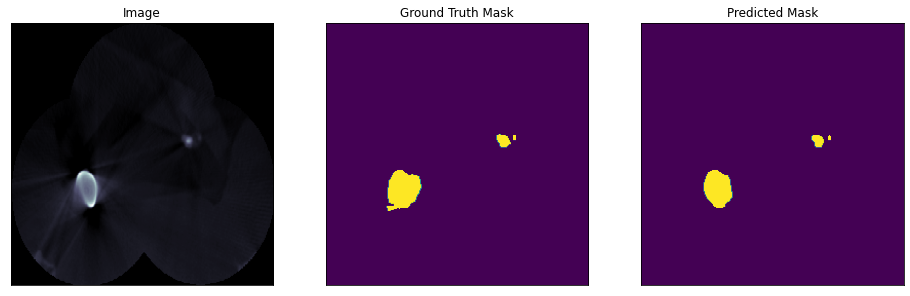

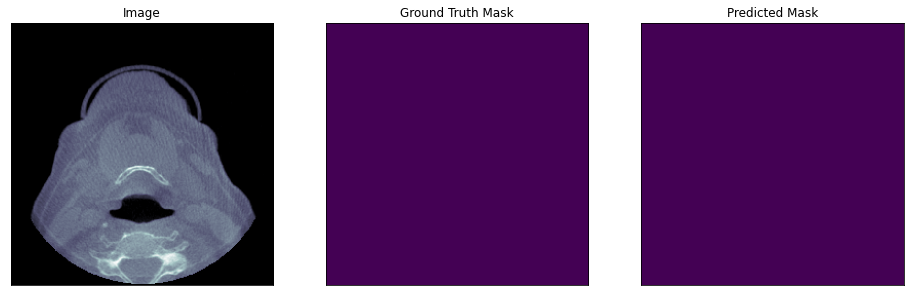

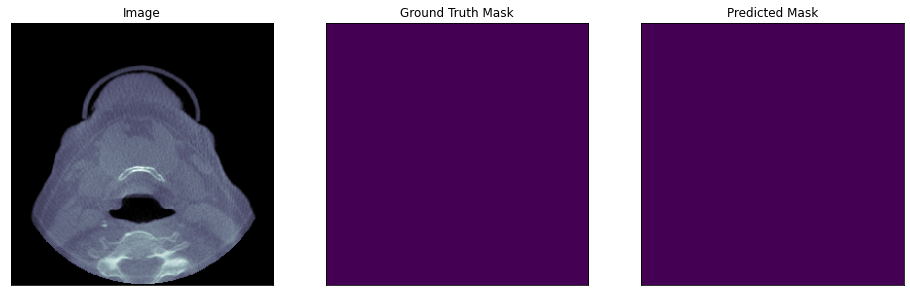

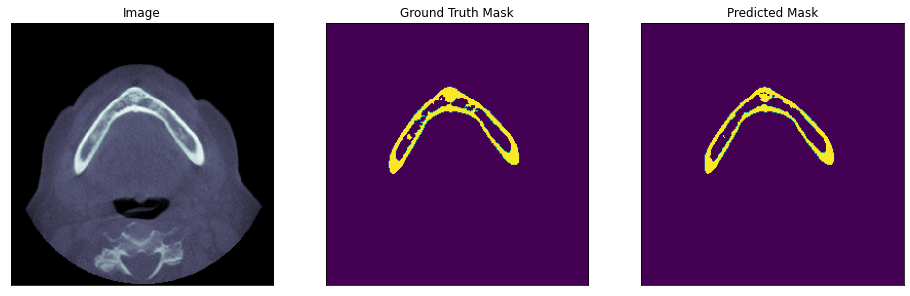

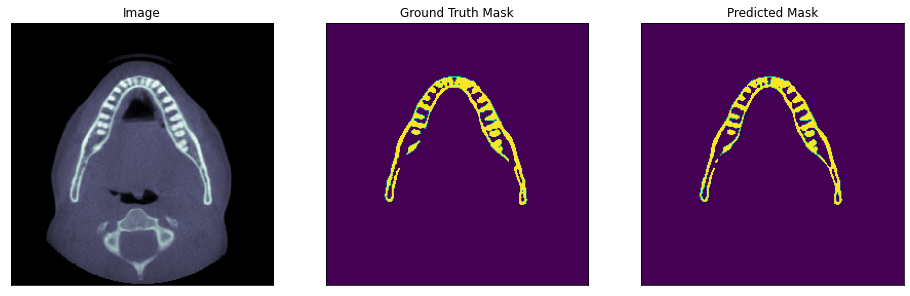

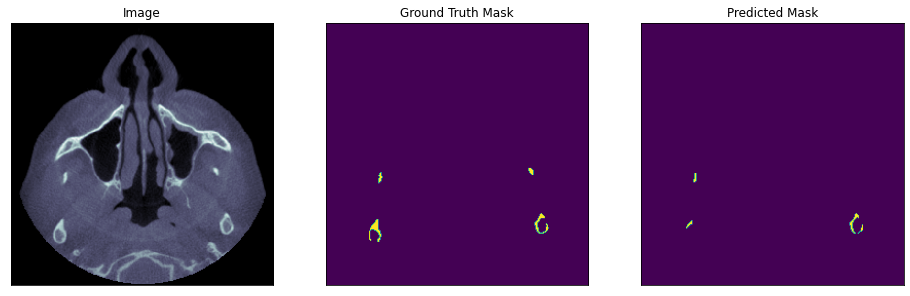

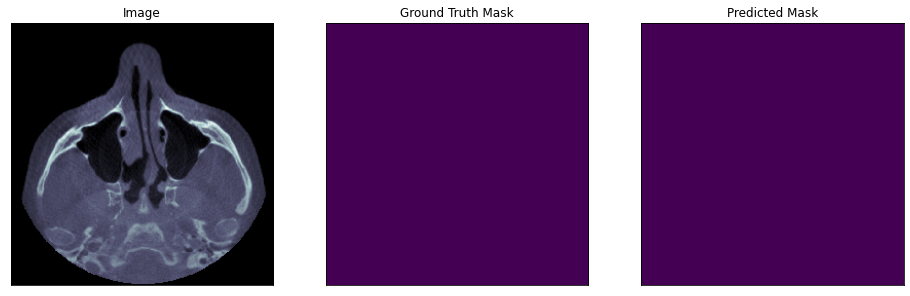

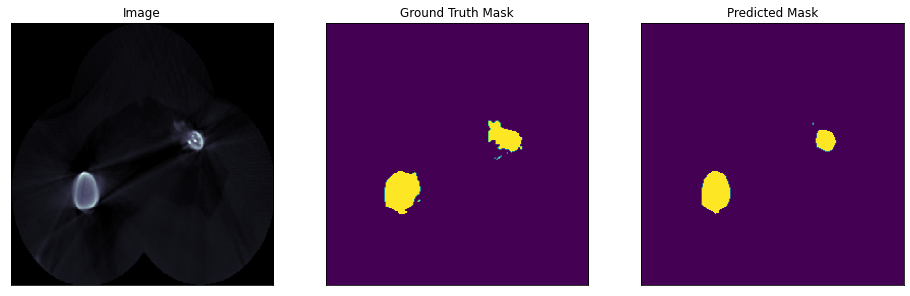

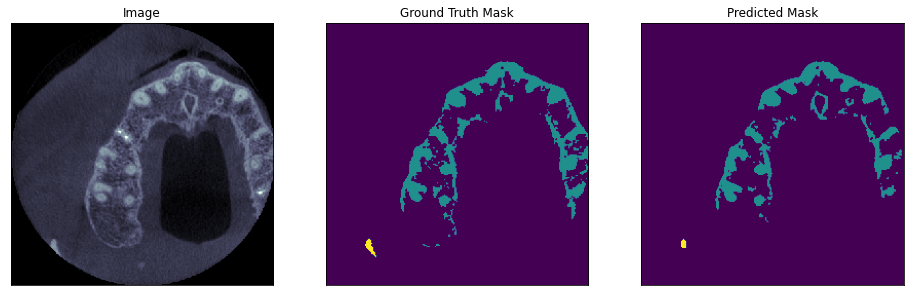

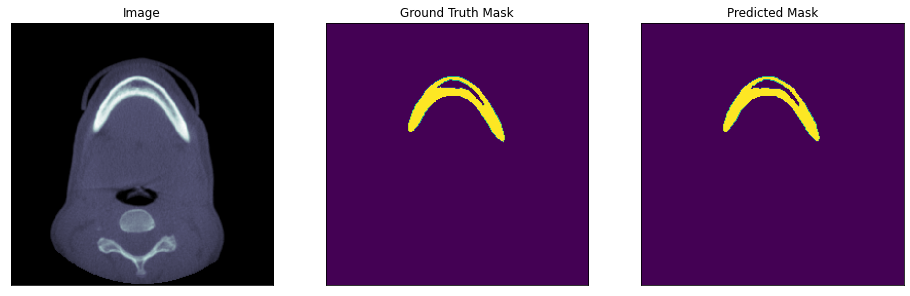

In [ ]:
#visualize some of the test results
visualize_results(axial_test_dataset,last_model_axial) # random samples

### coronal dataset testing

In [ ]:
#Dice score of test coronal dataset, since labels(ground truth values) are provided
last_model_coronal = torch.load('/content/drive/MyDrive/Colab Notebooks/last_model_coronal.pth')#save_model_coronal_path)
test_logs = val_epoch.run(coronal_test_loader)

valid: 100%|██████████| 455/455 [01:27<00:00,  5.23it/s, Dice_loss - 0.1054]


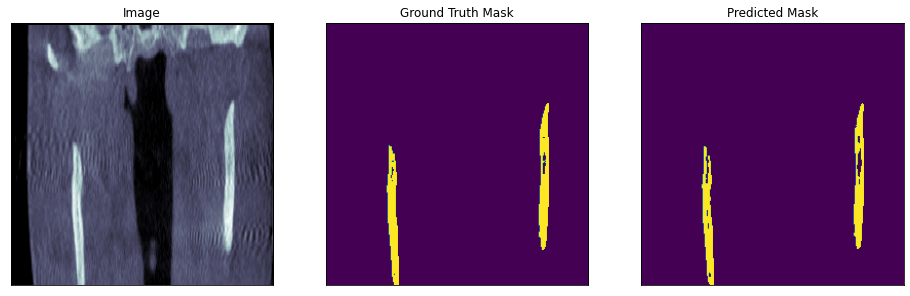

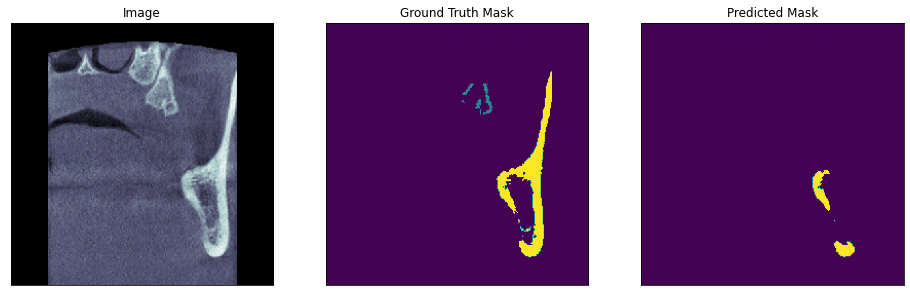

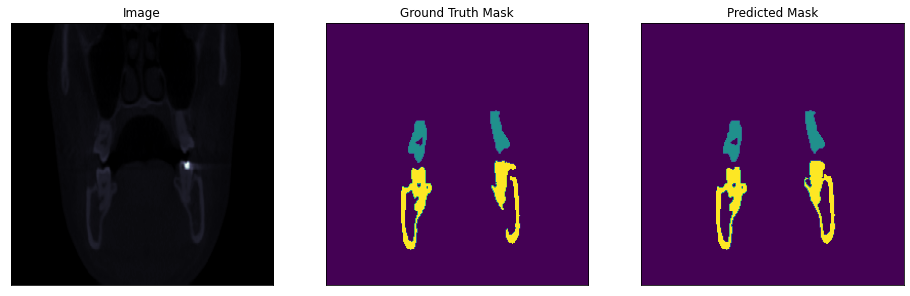

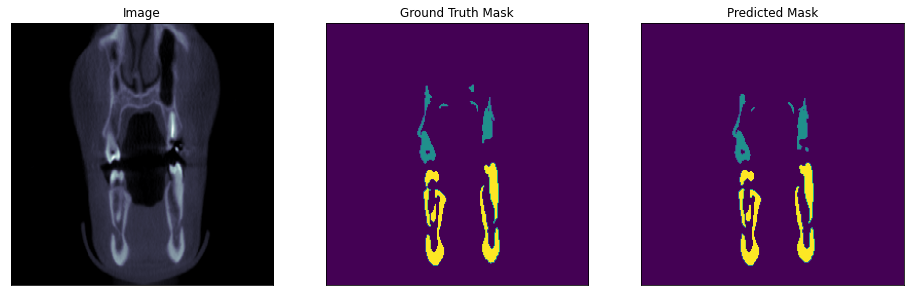

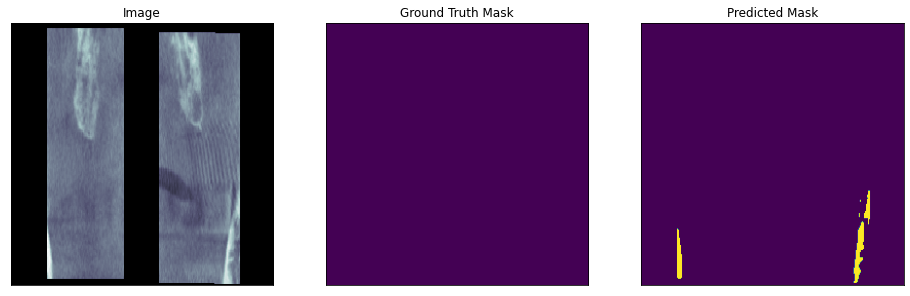

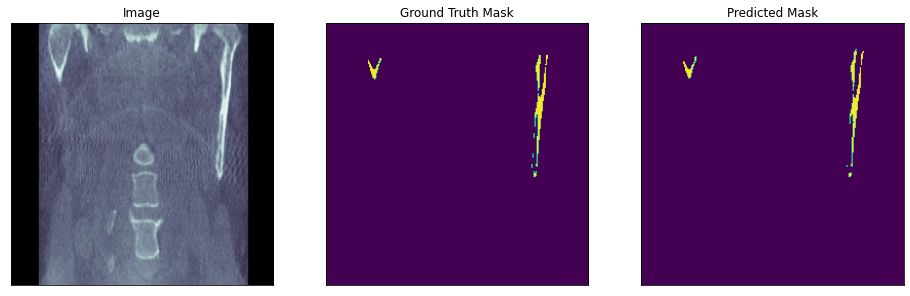

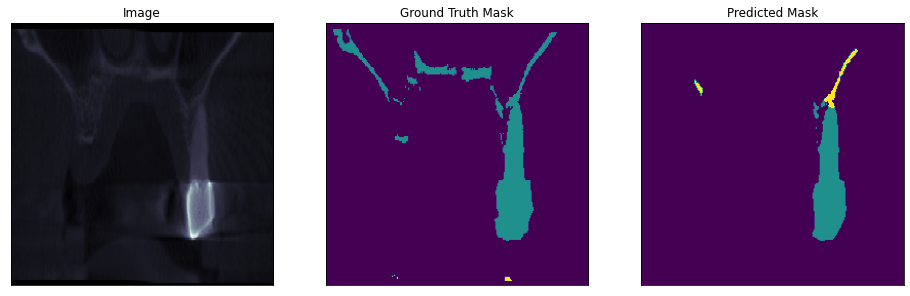

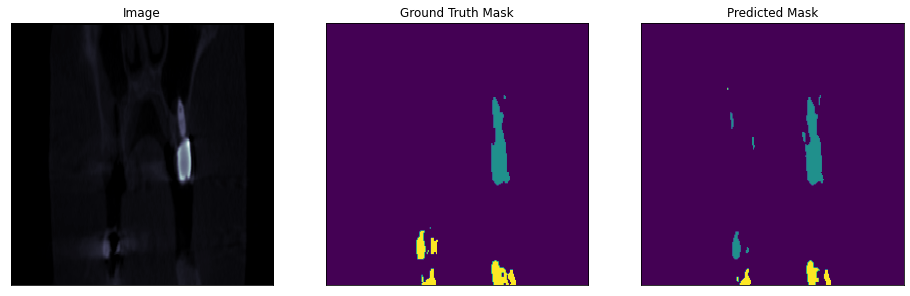

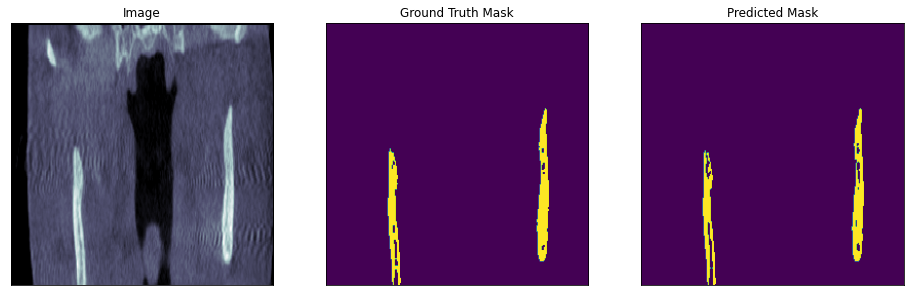

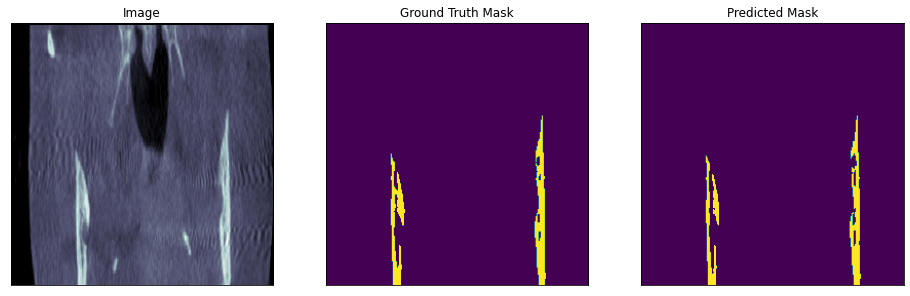

In [ ]:
#visualize some of the test results
visualize_results(coronal_test_dataset,last_model_coronal) # random samples

### sagittal dataset testing

In [84]:
last_model_sagittal = torch.load('/content/drive/MyDrive/Colab Notebooks/last_model_sagittal.pth')#save_model_sagittal_path)
test_logs = val_epoch.run(sagittal_test_loader)

valid: 100%|██████████| 455/455 [01:48<00:00,  4.21it/s, Dice_loss - 0.4737]


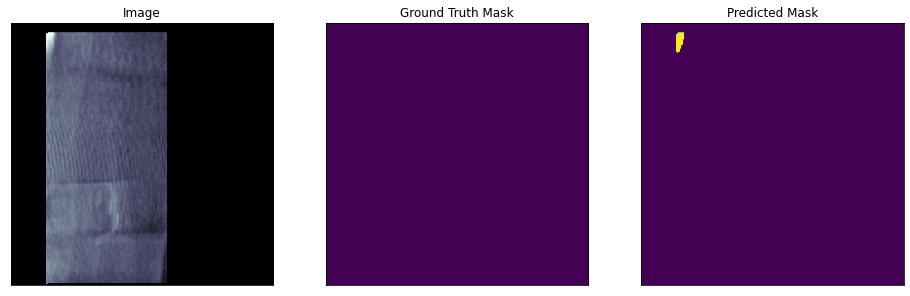

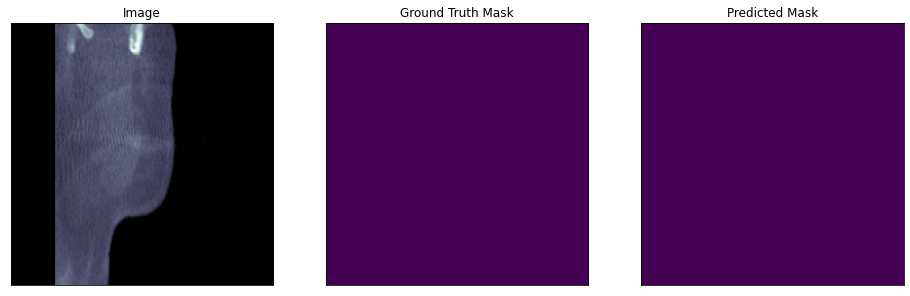

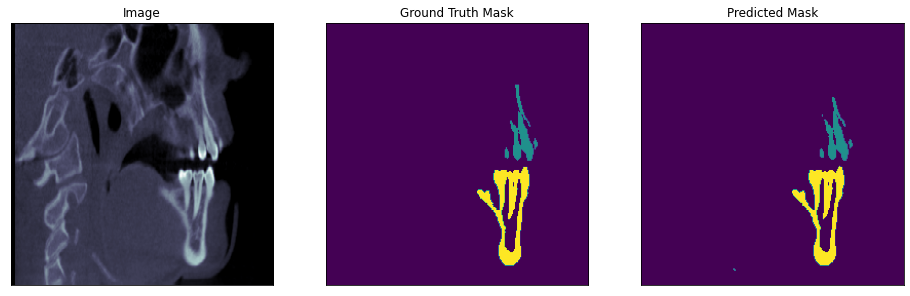

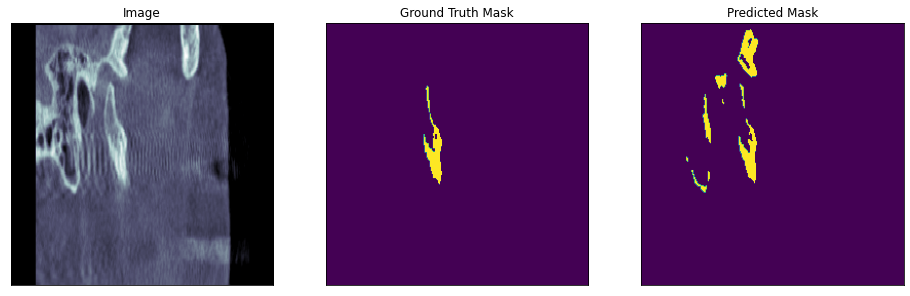

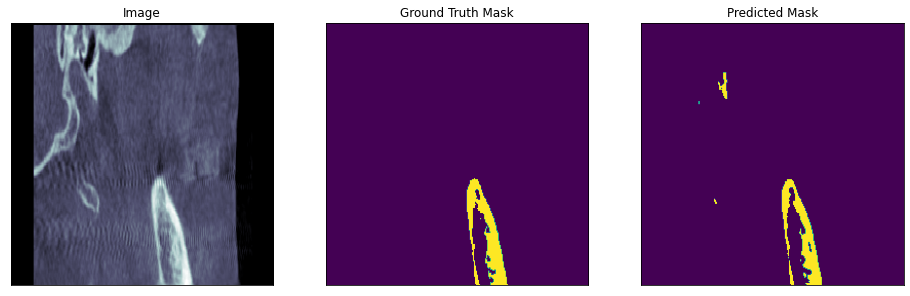

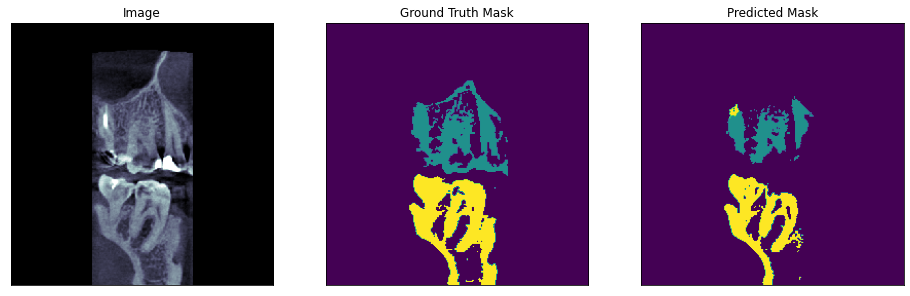

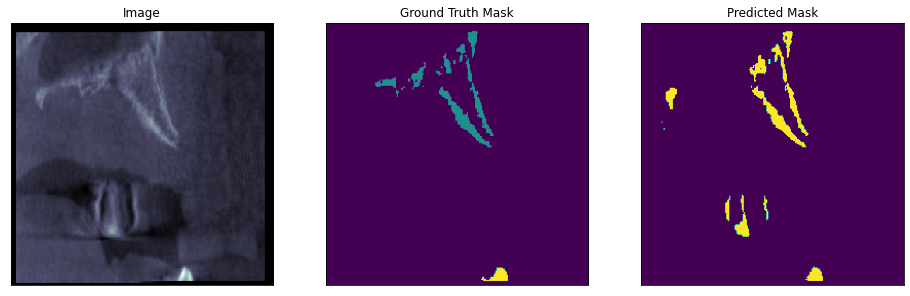

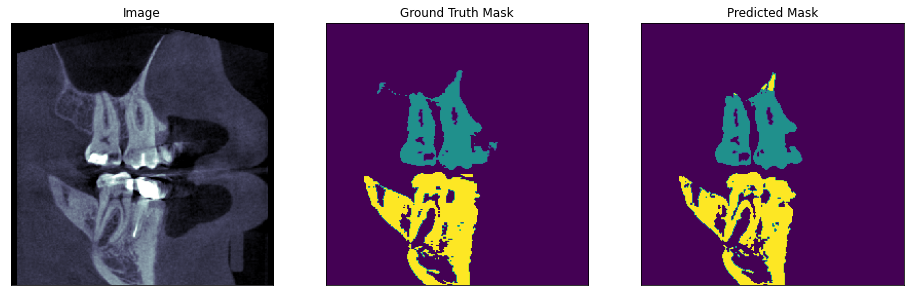

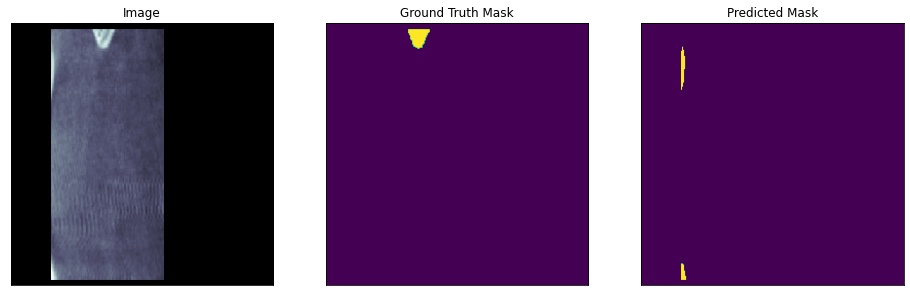

In [85]:
visualize_results(sagittal_test_dataset,last_model_sagittal) # random samples